In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


# Defining Data, parameters and common funcitons

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

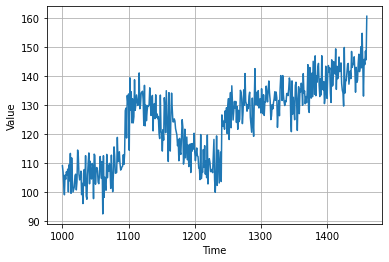

In [6]:
plot_series(time_valid, x_valid)

In [9]:
def window_data_gen(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda x: (x[:window_size], x[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [27]:
dataset = window_data_gen(x_train, window_size, batch_size, shuffle_buffer_size)

In [28]:
for (window_x, window_y) in dataset:
  print("train batch x shape : ", window_x.numpy().shape)
  print("train batch y shape : ", window_y.numpy().shape)
  print("Sample x => ", window_x[0].numpy())
  print("Sample y => ", window_y[0].numpy())
  break

train batch x shape :  (32, 20)
train batch y shape :  (32,)
Sample x =>  [69.10134  74.36482  60.502842 76.68438  68.31821  67.04559  64.19138
 61.049683 73.51203  69.83512  63.09121  63.138268 68.00752  78.10447
 68.53446  62.389908 68.75025  68.68882  56.641605 69.928314]
Sample y =>  69.118996


In [29]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(20, activation='relu', input_shape=[window_size]),
                             tf.keras.layers.Dense(10, activation='relu'),
                             tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [31]:
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 70.5232
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 50.2412
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 49.4503
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 48.2811
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 47.9792
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 47.2709
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 46.6935
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 46.2534
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 47.5174
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 45.6713
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 45.0930
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 44.9455
Epoch 13/100
31/31 [=====

In [32]:
model.predict(series[split_time-window_size:split_time][np.newaxis])[0][0]

103.59671

In [33]:
forecast = []
for index in range(split_time, len(series)):
  forecast.append(model.predict(series[index-window_size:index][np.newaxis])[0][0])

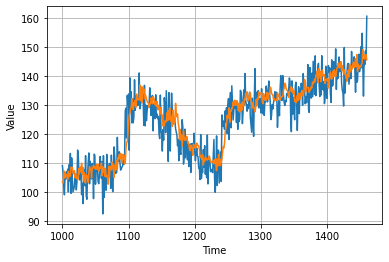

In [34]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [38]:
print(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy())

4.7805953


# Find optimal learning rate

In [48]:
dataset = window_data_gen(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.Sequential([
                             tf.keras.layers.Dense(20, activation='relu', input_shape=[window_size]),
                             tf.keras.layers.Dense(10, activation='relu'),
                             tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

history = model.fit(dataset, epochs=100, verbose=1, callbacks=[callback])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 9997.2832
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 4139.5078
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 1449.1052
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 441.4470
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 130.8005
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 63.9339
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 52.0924
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 50.7703
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 50.5634
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 50.4287
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 50.2576
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 50.1167
Epoch 13/100
31/3

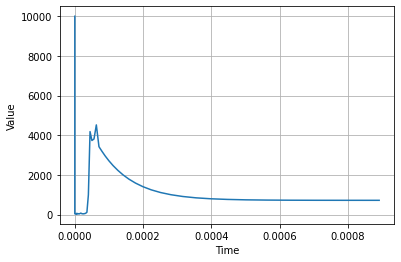

In [49]:
epoch = np.arange(100)
epoch = 1e-8 * 10**(epoch / 20)
plot_series(epoch, history.history["loss"])

(1e-08, 0.001, 0.0, 300.0)

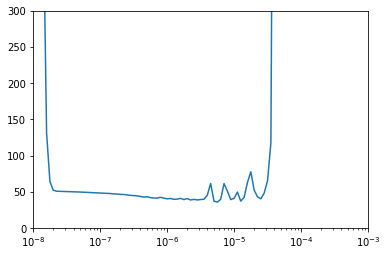

In [50]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

### Optimal loss looks like => Bigger than 10^-6 but smaller than 10^-5 => we will keep it 8e-6

In [56]:
dataset = window_data_gen(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.Sequential([
                             tf.keras.layers.Dense(20, activation='relu', input_shape=[window_size]),
                             tf.keras.layers.Dense(10, activation='relu'),
                             tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9))

history = model.fit(dataset, epochs=500, verbose=2)

Epoch 1/500
31/31 - 1s - loss: 1912.6611
Epoch 2/500
31/31 - 0s - loss: 86.5409
Epoch 3/500
31/31 - 0s - loss: 46.5537
Epoch 4/500
31/31 - 0s - loss: 67.7435
Epoch 5/500
31/31 - 0s - loss: 60.8206
Epoch 6/500
31/31 - 0s - loss: 45.6616
Epoch 7/500
31/31 - 0s - loss: 47.0874
Epoch 8/500
31/31 - 0s - loss: 52.9215
Epoch 9/500
31/31 - 0s - loss: 54.7784
Epoch 10/500
31/31 - 0s - loss: 51.1766
Epoch 11/500
31/31 - 0s - loss: 45.6081
Epoch 12/500
31/31 - 0s - loss: 45.8810
Epoch 13/500
31/31 - 0s - loss: 43.9859
Epoch 14/500
31/31 - 0s - loss: 48.1960
Epoch 15/500
31/31 - 0s - loss: 50.9517
Epoch 16/500
31/31 - 0s - loss: 51.6694
Epoch 17/500
31/31 - 0s - loss: 67.1735
Epoch 18/500
31/31 - 0s - loss: 57.6258
Epoch 19/500
31/31 - 0s - loss: 39.6017
Epoch 20/500
31/31 - 0s - loss: 64.2826
Epoch 21/500
31/31 - 0s - loss: 44.5587
Epoch 22/500
31/31 - 0s - loss: 48.2693
Epoch 23/500
31/31 - 0s - loss: 54.6055
Epoch 24/500
31/31 - 0s - loss: 44.5387
Epoch 25/500
31/31 - 0s - loss: 39.5936
Epoch 2

In [57]:
forecast = []
for index in range(split_time, len(series)):
  forecast.append(model.predict(series[index-window_size:index][np.newaxis])[0][0])

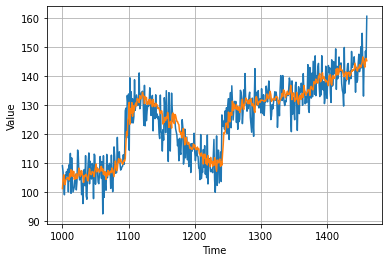

In [58]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [59]:
print(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy())

4.5251994
